# Basic signal processing with Python

<img width=150px src="https://upload.wikimedia.org/wikipedia/fr/thumb/1/16/Institut_de_physique_du_globe_de_paris_logo.svg/1200px-Institut_de_physique_du_globe_de_paris_logo.svg.png">

_Made by Alexandre Fournier (fournier@ipgp.fr), modified by Léonard Seydoux (seydoux@ipgp.fr) in 2023 for the course "Scientific Computing for Geophysical Problems" at the [institut de physique du globe de Paris](http://www.ipgp.fr)._

## Table of contents

1. [Introduction](#1.-Introduction)
    1. [Goals](#1.1.-Goals)
    2. [Importing modules](#1.2.-Importing-modules)
2. [First, with synthetic data](#2.-First,-with-synthetic-data)
    1. [Synthetic example](#2.1.-Synthetic-example)
    2. [Multi-component synthetic example](#2.2.-Multi-component-synthetic-example)
    3. [Spectral analysis](#2.3.-Spectral-analysis)
    4. [Filtering](#2.4.-Filtering)
3. [A real case: 78 years of geomagnetic measurements at Chambon-la-Forêt](#3.-A-real-case:-78-years-of-geomagnetic-measurements-at-Chambon-la-Forêt)
    1. [Reading the data](#3.1.-Reading-the-data)
    2. [Spectral analysis](#3.2.-Spectral-analysis)
    3. [Filtering](#3.3.-Filtering)
    4. [Correlating with the sunspot number](#3.4.-Correlating-with-the-sunspot-number) 


## 1. Introduction

### 1.1. Goals

This Jupyter Notebook provides examples of basic signal processing with Python. It covers topics such as generating synthetic time series, computing Fourier transforms, and applying filters to signals. The examples use the `numpy`, `scipy`, and `matplotlib` libraries. The notebook is organized into cells, each containing a block of code that can be executed independently. If a module is already imported in a cell, it can be used in other cells as well. For the same reason, if a variable is defined in a cell, it can be used in other cells as well. We should not repeat the same import or variable definition in multiple cells, unless we want to overwrite the previous definition.

To get started, run the cells in order, starting from the top. Each cell builds on the previous one, so it's important to run them in order. Note that this notebook assumes some familiarity with Python and signal processing concepts. If you're new to these topics, you may want to review some introductory material before diving in. Every python function is documented on the internet. google the name of the function will provide you with the link to its online description. For example, see
[http://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html](http://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html).

Made in 2023 by Alexandre Fournier (fournier@ipgp.fr) and Leonard Seydoux (seydoux@ipgp.fr).

### 1.2. Importing modules


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal 

import synthetic

## 2. First, with synthetic data

### 2.1. Synthetic example

In this section, we will generate a synthetic timeseries using the `synthetic.py` module. The timeseries will span from 1850 to 2010, and will contain a single harmonic component of period 10 years. The timeseries will be evenly sampled every 12th of a year (_i.e._, every month). To generate the synthetic timeseries, we will use the `time_range` and `sine()` functions from the `synthetic.py` module. These functions allow us to define a time window and a cosine time series, respectively.

> __Question 1.__ What is the maximum time step that we can use to sample the synthetic timeseries? Can you give a general formula for the minimum time step that we can use to sample a timeseries with a given period?

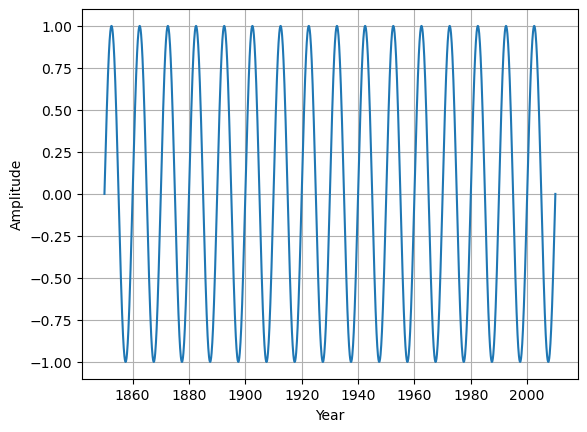

In [2]:
# Time extent of the time series
time_start = 1850
time_end = 2010
time_step = 1 / 12
times = synthetic.time_range(time_start, time_end, time_step)

# Generate a synthetic time series
period = 10.0
amplitude = 1.0
phase = -2 * np.pi * time_start / period
time_series = synthetic.sine(times, period, amplitude, phase)

# Plot
fig, ax = plt.subplots()
ax.plot(times, time_series)
ax.set_xlabel("Year")
ax.set_ylabel("Amplitude")
ax.grid()

# Show
plt.show()

### 2.2. Multi-component synthetic example

We will now generate synthetic data with multiple frequency components and analyse them.

> __Question 2.__. Using the python functions at your disposal in the `synthetic.py` module, create a synthetic timeseries spanning the 1850 to 2010 time range (with one point every month), comprising four harmonic components, of periods in years given by
>
> $$
> \left \{
> \begin{align*}
> T_1 &= 0.5, \\
> T_2 &= 1, \\
> T_3 &= 11, \\
> T_4 &= 60. \\
> \end{align*} 
> \right .
> $$
>
> You can arbitrarily set the amplitude $A_i$ and the phase $\varphi_i$ of each of these components. The signal $s(t)$ so created reads 
> 
> $$s(t) = \sum_{i=1}^{i=4} s_i(t) = \sum_{i=1}^{i=4} A_i \cos \left( 2 \pi t / T_i +\varphi_i \right). $$

In [3]:
# Your code goes here

###@.3 Spectral analysis

We wish to perform the spectral analysis of $s(t)$ and therefore to compute its (discrete) Fourier transform. Let $\hat{s}(f)$ denote this transform, with $f$ the frequency (inverse of the period) keeping in mind that the angular frequency $\omega=2\pi f$. To compute $\hat{s}(f)$, we resort to python again, in particular to the `np.fft.rfft` method. An example of its usage is given in the piece of code below, where the spectral analysis is performed on the harmonic example I gave above.

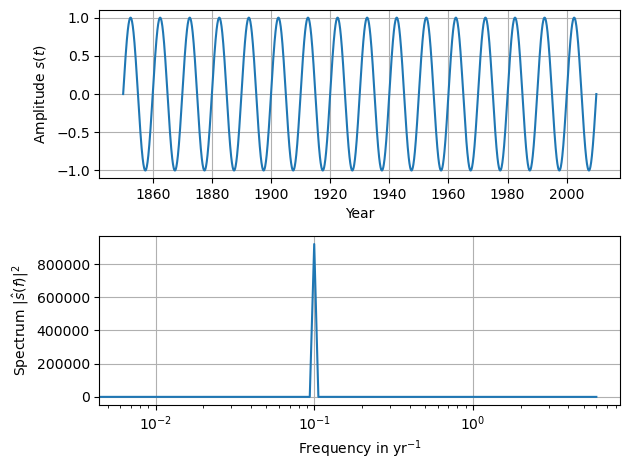

In [4]:
# Compute Fourier transform
nfft = len(time_series)
spectrum = np.fft.rfft(time_series, n=nfft)

# Calculate frequencies
frequencies = np.fft.rfftfreq(nfft, time_step)

# Prepare the plot
fig, ax = plt.subplots(2)

# Plot the time series
ax[0].plot(times, time_series)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Amplitude $s(t)$")
ax[0].grid()

# Plot the spectrum
ax[1].semilogx(frequencies, np.abs(spectrum) ** 2)
ax[1].set_xlabel("Frequency in yr$^{-1}$")
ax[1].set_ylabel(r"Spectrum $|\hat{s}(f)|^2$")
ax[1].grid()

# Show
fig.tight_layout()
plt.show()

> __Question 3.__ Adapt the code below to the multi-component signal you created in 1.2. Plot the spectrum of the signal. What do you observe?

In [5]:
# Your code goes here

### 2.4. Filtering

Now let us get acquainted with the Butterworth filters provided by the `scipy.signal` processing package of scientific python. The example below shows how to apply a bandpass filter, with corner periods equal to 5 and 15 yr, to the example timeseries I have been using so far. 

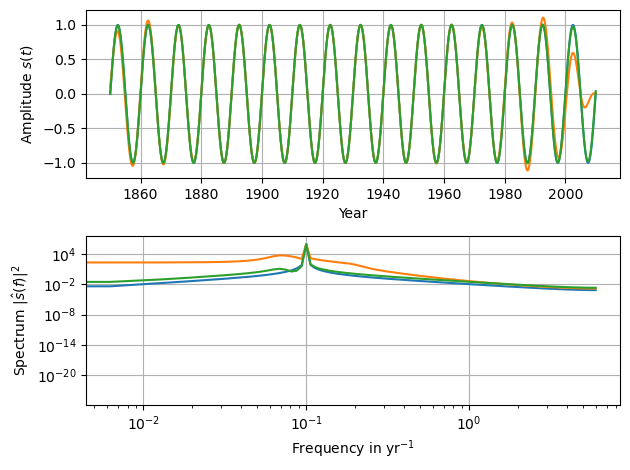

In [6]:
# Butterworth filter properties
period_max = 15
period_min = 5

# Get the Nyquist frequency
sampling_rate = 1 / time_step
nyquist_frequency = sampling_rate / 2

# Convert to angular frequencies
frequency_low = 1 / period_max
omega_low = frequency_low / nyquist_frequency
frequency_high = 1 / period_min
omega_high = frequency_high / nyquist_frequency

# Filter order
b, a = signal.butter(4, [omega_low, omega_high], btype="bandpass")

# Filter the time series
time_series_filtered = signal.filtfilt(b, a, time_series)
time_series_filtered_pad = signal.filtfilt(b, a, time_series, padlen=400)

# Get spectrum
spectrum = np.fft.rfft(time_series, n=nfft)
spectrum_filtered = np.fft.rfft(time_series_filtered, n=nfft)
spectrum_filtered_pad = np.fft.rfft(time_series_filtered_pad, n=nfft)

# Prepare the plot
fig, ax = plt.subplots(2)

# Plot the time series
ax[0].plot(times, time_series)
ax[0].plot(times, time_series_filtered)
ax[0].plot(times, time_series_filtered_pad)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Amplitude $s(t)$")
ax[0].grid()

# Plot the spectrum
ax[1].loglog(frequencies, np.abs(spectrum) ** 2)
ax[1].loglog(frequencies, np.abs(spectrum_filtered) ** 2)
ax[1].loglog(frequencies, np.abs(spectrum_filtered_pad) ** 2)
ax[1].set_xlabel("Frequency in yr$^{-1}$")
ax[1].set_ylabel(r"Spectrum $|\hat{s}(f)|^2$")
ax[1].grid()

# Show
fig.tight_layout()  
plt.show()

> __Question 4.__. Your turn now: extract in $s(t)$ the $11$-yr component. Plot the filtered signal against the original one, and compare as well its spectrum to the original one. By looking at the manual page of `scipy.signal.filtfilt`, the default version of which we use, suggest a way of improving the reconstruction of the sought harmonic component. This improvement can follow from the artificial augmentation of the length of the timeseries (padding it with zeroes), which tends to mitigate spurious edge effects on the filtered signal.

In [7]:
# Your code goes here

## 3. A real case: 78 years of geomagnetic measurements at Chambon-la-Forêt

We will now analysis the geomagnetic measurements recorded at the geomagnetic observatory of Chambon-la-Forêt (CLF), France. The data are provided by the [Bureau Central de Magnétisme Terrestre](http://www.bcmt.fr) (BCMT). The data are stored in the file `data/chambon_la_foret-2014.dat`. The file contains the monthly means of the geomagnetic elements recorded at the CLF observatory. 

### 3.1. Reading the data

The cell below reads the file and and plots the fluctuations of the vertical component ($Z$) at the site between 1936 and 2015. 

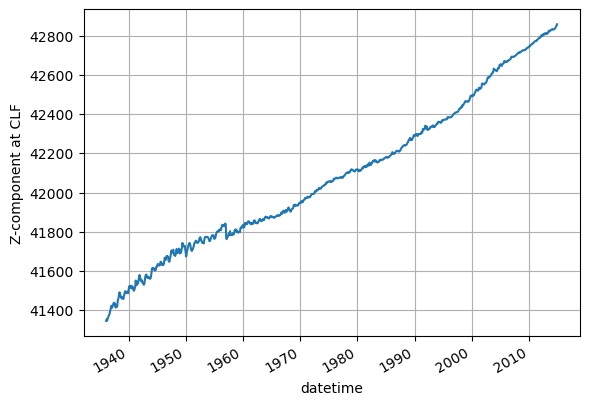

In [8]:
filename = "data/chambon_la_foret.dat"

# Read the data
data = pd.read_fwf(filename, skiprows=9, strip=True)

# Turn years into datetime objects
data["datetime"] = pd.to_datetime(data.date.astype(str) + " " + data.time.astype(str))
data.drop(["date", "time", "doy"], axis=1, inplace=True)
data.set_index("datetime", inplace=True)

# Show the data
ax = data.clfz.plot(grid=True, ylabel="Z-component at CLF")
plt.show()

### 3.2. Spectral analysis

> __Question 5.__ Write your own code to compute and plot $X(t)$ at the observatory CLF, $X$ being the Northward component, whose connection with the horizontal component and the declination is given in the header above. Based on the expertise you gained in the first synthetic part of this lab, compute $\hat{X}(f)$ and plots the power spectral density of $X$. It is recommended to have $X(t)$ and $|\hat{X}|^2(f)$ on the same plot (with two graphs). Analyze the spectrum so obtained. Are there any obvious peaks? Which periods do they correspond to? Can you make sense of them? 

In [9]:
data["clfx"] = data.clfh * np.cos(np.radians(data.clfd))

# What's next? 

### 3.3. Filtering

> __Question 5.__ Write another piece of code to filter out the long-period component of $X(t)$, with periods greater than 15~years, say. Plot the original $X(t)$ and its filtered version $X'(t)$ on one graph, and the spectra of $|\hat{X}|^2(f)$ and $|\hat{X'}|^2(f)$ on a second graph (both graphs on the same plot). 

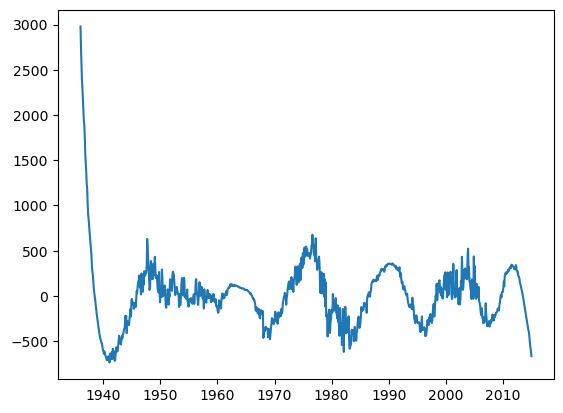

In [10]:
# Butterworth filter properties
period_max = 15

# Get the Nyquist frequency
sampling_rate = 1 / time_step
nyquist_frequency = sampling_rate / 2

# Convert to angular frequencies
frequency_low = 1 / period_max
omega_low = frequency_low / nyquist_frequency

# Filter order
b, a = signal.butter(4, omega_low, btype="highpass")

# Filter the time series
clf_filtered = signal.filtfilt(b, a, data.clfx, padlen=100, padtype="even")

plt.figure()
plt.plot(data.index, clf_filtered, label="Filtered")
plt.show()

### 3.4. Correlating with the sunspot number

The file `data/sunspot_number.dat` contains monthly values of the sunspot number (a proxy for solar activity) between 1749 and 2016. 

> __Question 6.__ Write a piece of code to read the file `data/sunspot_number.dat` and extract the sunspot number $S(t)$ for the same period of time as the geomagnetic data. Plot $S(t)$ and $X'(t)$ on the same graph. What do you observe? Propose an explanation for the correlation between the two time series.

In [11]:
# Your code goes here